In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from helpers import clean_google, stitch_series, plot_missing, plot_google
import seaborn as sns
from datetime import datetime

<h3>Google Trends Data</h3>

In [5]:
# Import folder path from config file
from config import GOOGLE_PATH
path = GOOGLE_PATH

# List all files in google_search_trends folder
all_files = [file for file in os.listdir(path)]

# Create dict for abbreviation mapping
cantons = {'Zürich':'ZH', 'Zug':'ZG', 'Uri':'UR', 'Nidwalden':'NW', 'Obwalden':'OW', 'Thurgau':'TG', 'Freiburg':'FR', 'Neuenburg':'NE', 'Genf':'GE', 'Jura':'JU', 'Wallis':'VS', 'Waadt':'VD', 'Graubünden':'GR', 'Sankt_Gallen':'SG', 'Tessin':'TI', 'Schwyz':'SZ', 'Schaffhausen':'SH', 'Luzern':'LU', 'Glarus':'GL', 'Basel-Stadt':'BS', 'Basel-Landschaft':'BL', 'Bern':'BE', 'Aargau':'AG', 'Appenzell_Innerrhoden':'AI', 'Appenzell_Ausserrhoden':'AR', 'Solothurn':'SO'}  
# Reverse for reverse lookup
cantons_rev = dict()
for key, value in cantons.items():
    cantons_rev[value] = key

In [10]:
# Load countrywide data
ch_2013 = clean_google(pd.read_csv(path+f'2013_CH_husten_fieber.csv', skiprows=2))
ch_2017 = clean_google(pd.read_csv(path+f'2017_CH_husten_fieber.csv', skiprows=2))
ch_2022 = clean_google(pd.read_csv(path+f'2022_CH_husten_fieber.csv', skiprows=2))

# Merge country data
ch_merge_1 = stitch_series('Schweiz', ch_2013, ch_2017)
ch_merge_2 = stitch_series('Schweiz', ch_2017, ch_2022)
ch_merge = stitch_series('Schweiz', ch_merge_1, ch_merge_2)
google_trends_ch = ch_merge.copy()

# Add cantonal data
for canton in cantons.keys():
    # Load cantonal data from folder
    file_names = list(filter(lambda x: cantons[canton] in x, all_files))
    canton_2013 = clean_google(pd.read_csv(path+f'2013_{cantons[canton]}_husten_fieber.csv', skiprows=2))
    canton_2017 = clean_google(pd.read_csv(path+f'2017_{cantons[canton]}_husten_fieber.csv', skiprows=2))
    canton_2022 = clean_google(pd.read_csv(path+f'2022_{cantons[canton]}_husten_fieber.csv', skiprows=2))

    # Merge cantonal data
    canton_merge_1 = stitch_series(canton, canton_2013, canton_2017)
    canton_merge_2 = stitch_series(canton, canton_2017, canton_2022)
    canton_merge = stitch_series(canton, canton_merge_1, canton_merge_2)

    # Append to 
    google_trends_ch = pd.concat([google_trends_ch, canton_merge])

# Transpose
google_trends_ch = google_trends_ch.T

<h3>Google search activity per canton from 2013-2023</h3>

<h4>Plot search activity across all Cantons</h4>

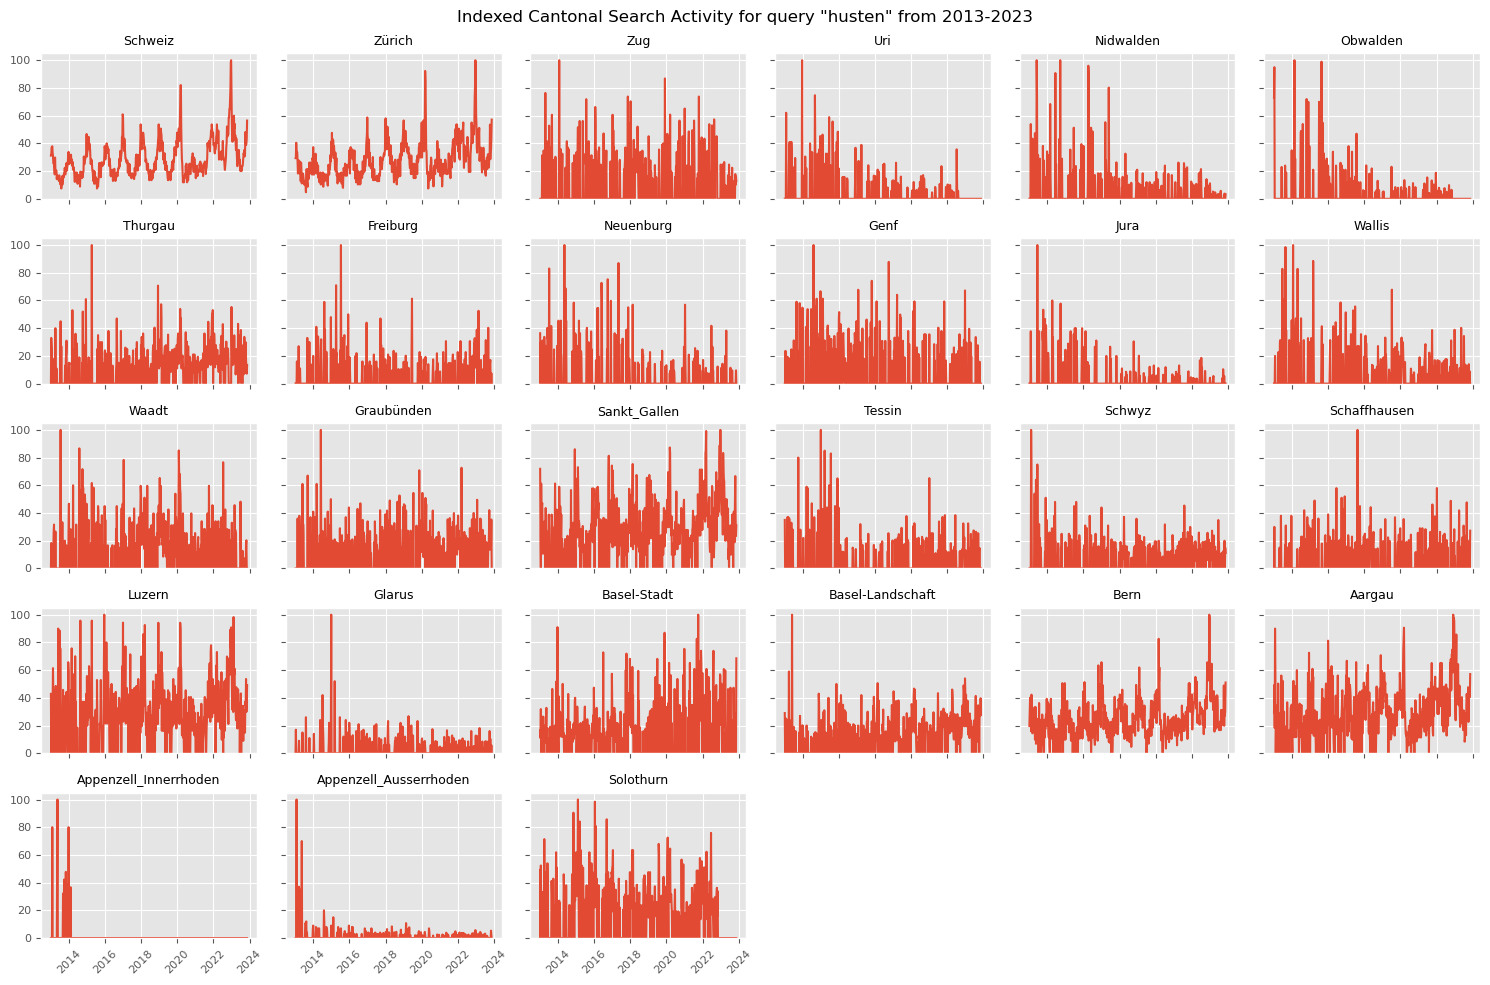

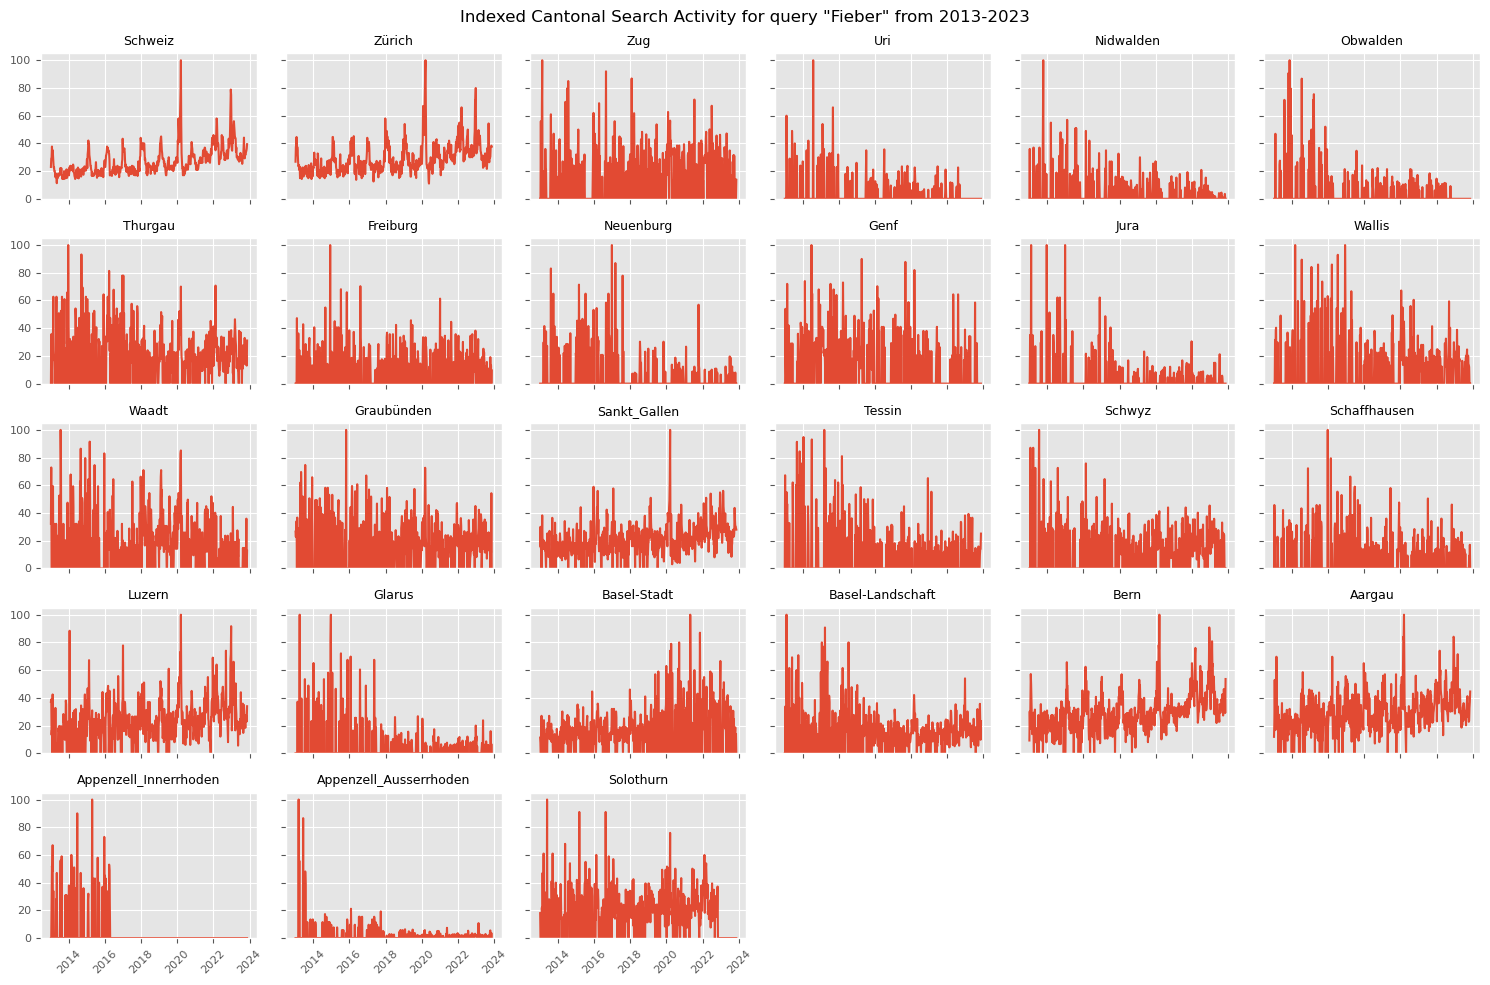

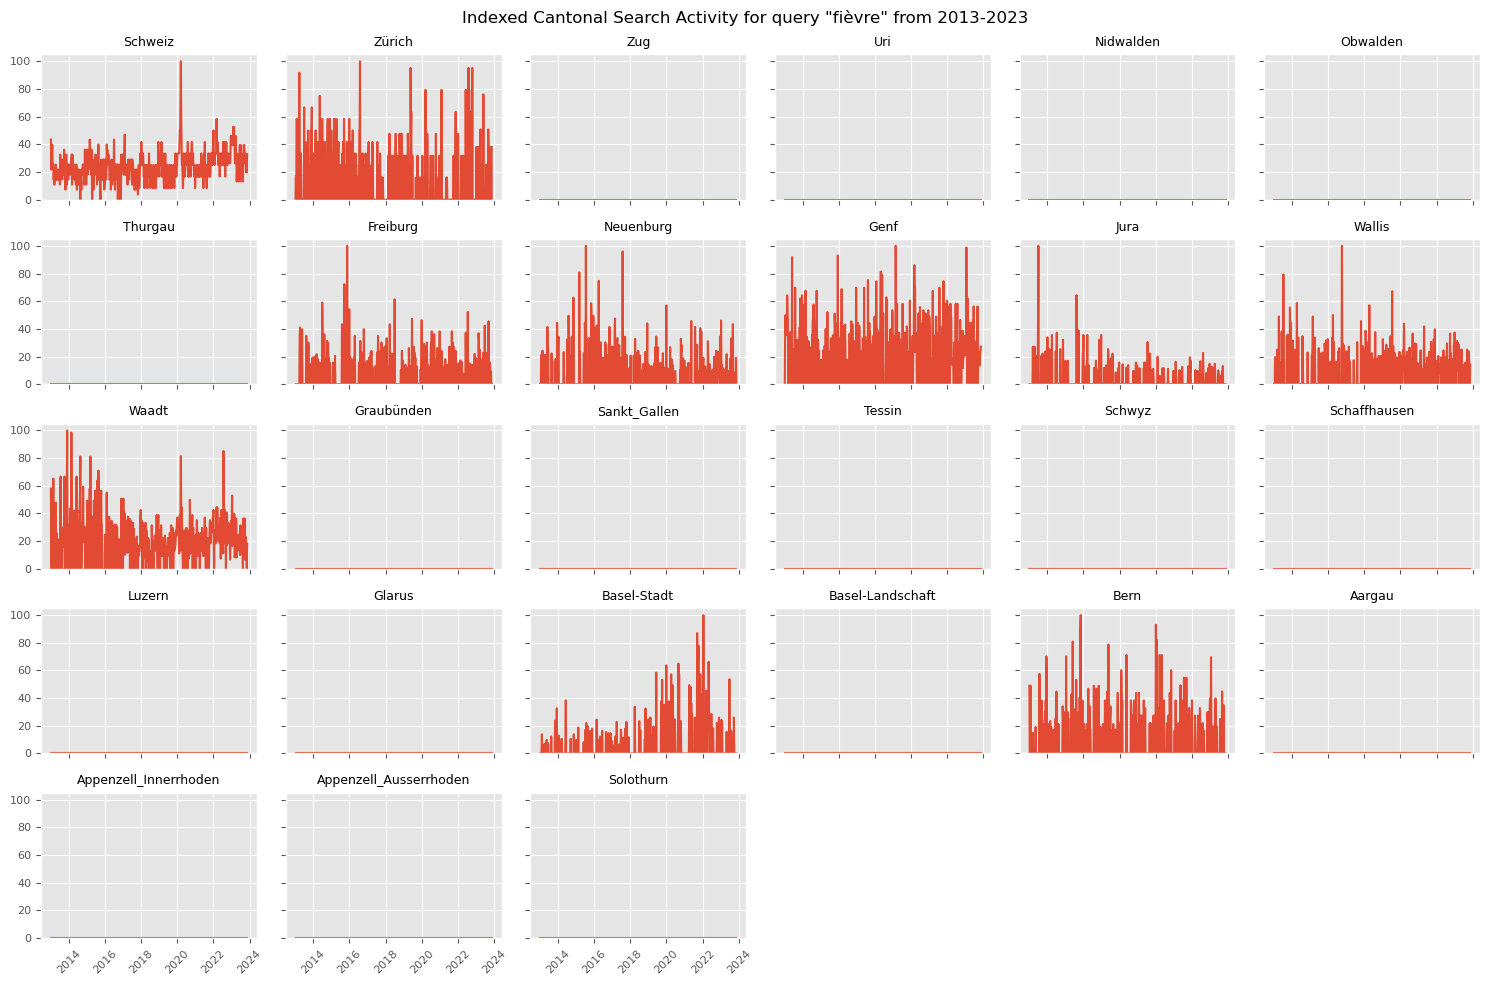

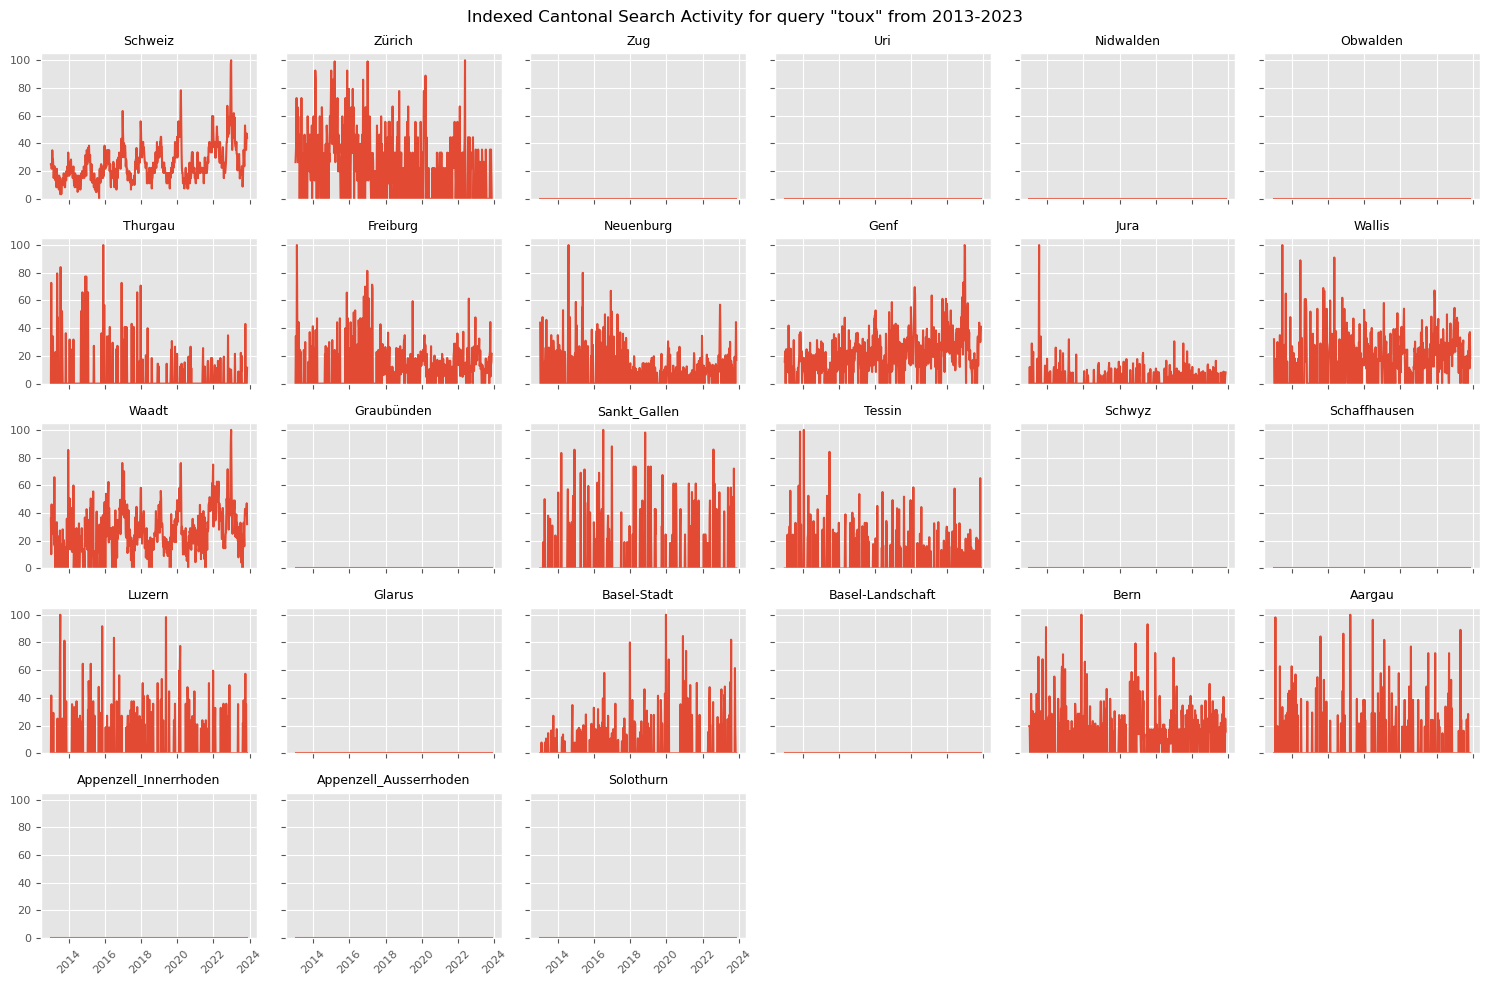

In [11]:
google_plot = google_trends_ch.copy()
google_plot.index = pd.to_datetime(google_plot.index)


# Iterate through each subplot and plot the data

queries = ['husten', 'Fieber', 'fièvre', 'toux']
for query in queries:
    # Plot each canton separately
    fig, ax = plt.subplots(5, 6, figsize=(15, 10), sharex=True, sharey=True)
    plt.style.use('ggplot')
    # Adjust the subplots' layout
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    # Set a common y-axis limit
    y_limit = 105
    i, j = 0, 0
    for canton in ['Schweiz', *cantons.keys()]:
        ax[i][j].plot(google_plot[canton, query], label=canton)
        ax[i][j].set_title(canton, fontsize=9)
        ax[i][j].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels
        ax[i][j].tick_params(axis='both', labelsize=8)  # Set tick label size
        ax[i][j].set_ylim([0, y_limit])  # Set y-axis limit for each subplot
        
        # Move to next subplot
        if j == 5:
            i += 1
            j = 0
        else:
            j += 1

    # Hide unused subplots
    for p in range(i, 5):
        for q in range(j, 6):
            ax[p][q].axis('off')

    # Add overarching title
    plt.suptitle(f'Indexed Cantonal Search Activity for query "{query}" from 2013-2023')

    # Adjust overall layout
    plt.tight_layout()

    plt.show()

<h4>Heatmaps of missing values</h4>

In [12]:
plot_nan = google_trends_ch.copy() # Create a copy for plotting heatmaps of missing values
plot_nan.columns = plot_nan.columns.map(("_").join) # Flatten levels of dataframe from multi-index to single index
plot_nan.replace(0, np.nan, inplace=True) # Replace 0s with np.nan

# Overview of absolute count and percentage of missing values in table format
nan_count = plot_nan.loc[:, :].isnull().sum()
nan_count_pct = round(nan_count / len(plot_nan.index), 2)
nan_df = pd.DataFrame([nan_count, nan_count_pct]).T
nan_df.columns = ['count', '%']
nan_df

count     %
Schweiz_Fieber                 0.0  0.00
Schweiz_fièvre                 6.0  0.01
Schweiz_husten                 0.0  0.00
Schweiz_toux                   1.0  0.00
Zürich_husten                  0.0  0.00
...                            ...   ...
Appenzell_Ausserrhoden_toux  567.0  1.00
Solothurn_husten             275.0  0.49
Solothurn_Fieber             206.0  0.36
Solothurn_fièvre             567.0  1.00
Solothurn_toux               567.0  1.00

[108 rows x 2 columns]

/Users/thorbenklabunde/Desktop/FW23/03_DataScience/project/DSF/notebooks/helpers.py:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


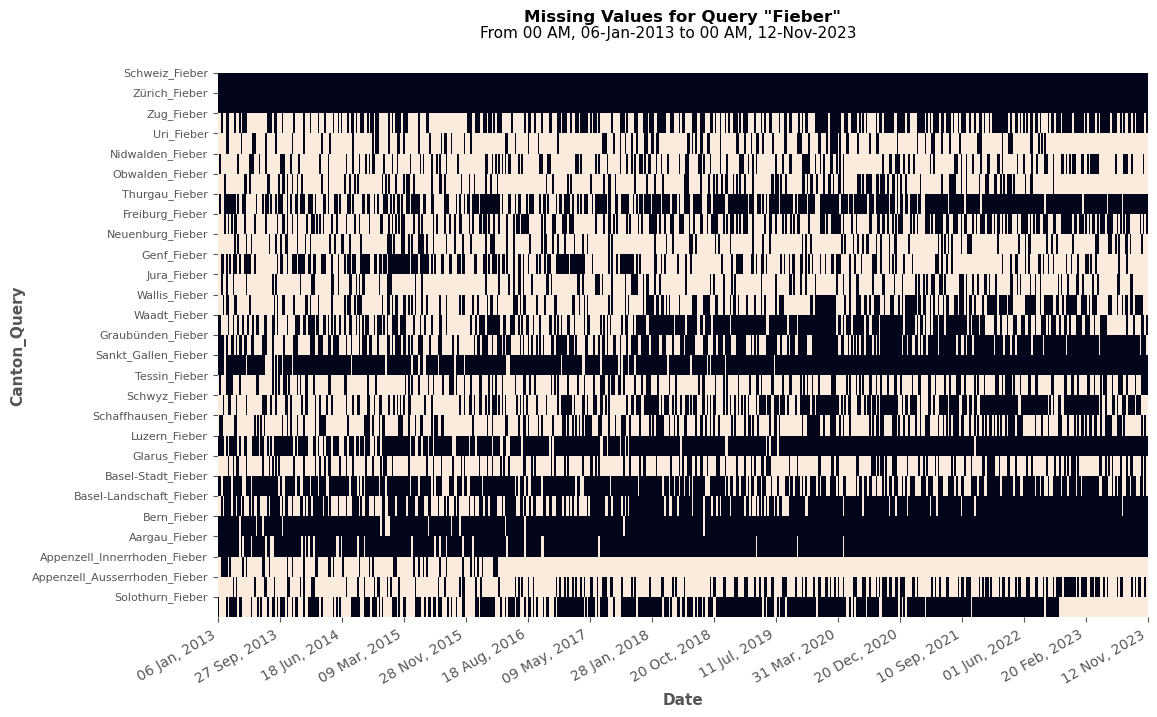

/Users/thorbenklabunde/Desktop/FW23/03_DataScience/project/DSF/notebooks/helpers.py:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


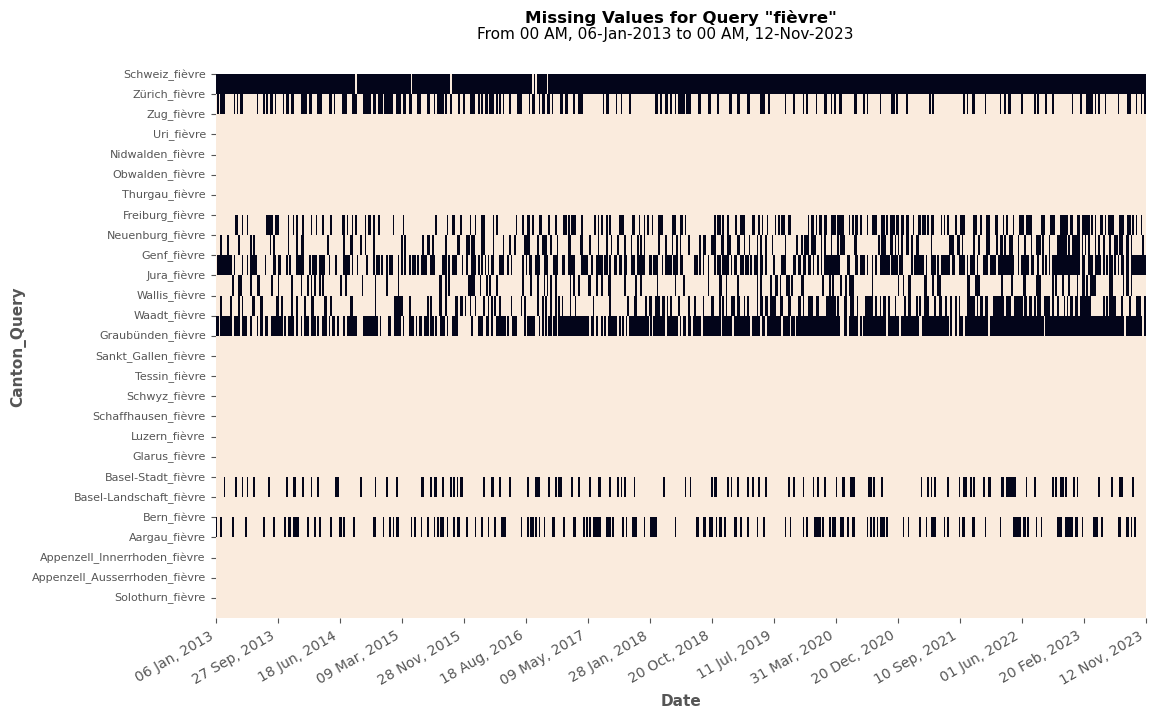

/Users/thorbenklabunde/Desktop/FW23/03_DataScience/project/DSF/notebooks/helpers.py:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


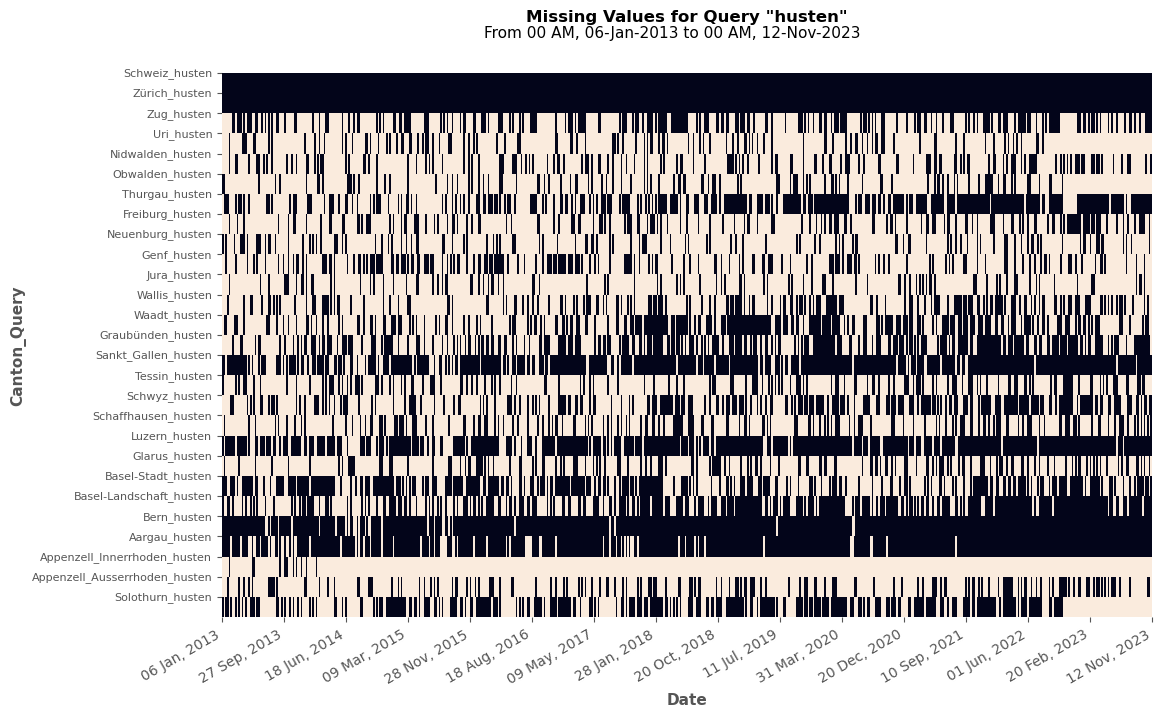

/Users/thorbenklabunde/Desktop/FW23/03_DataScience/project/DSF/notebooks/helpers.py:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


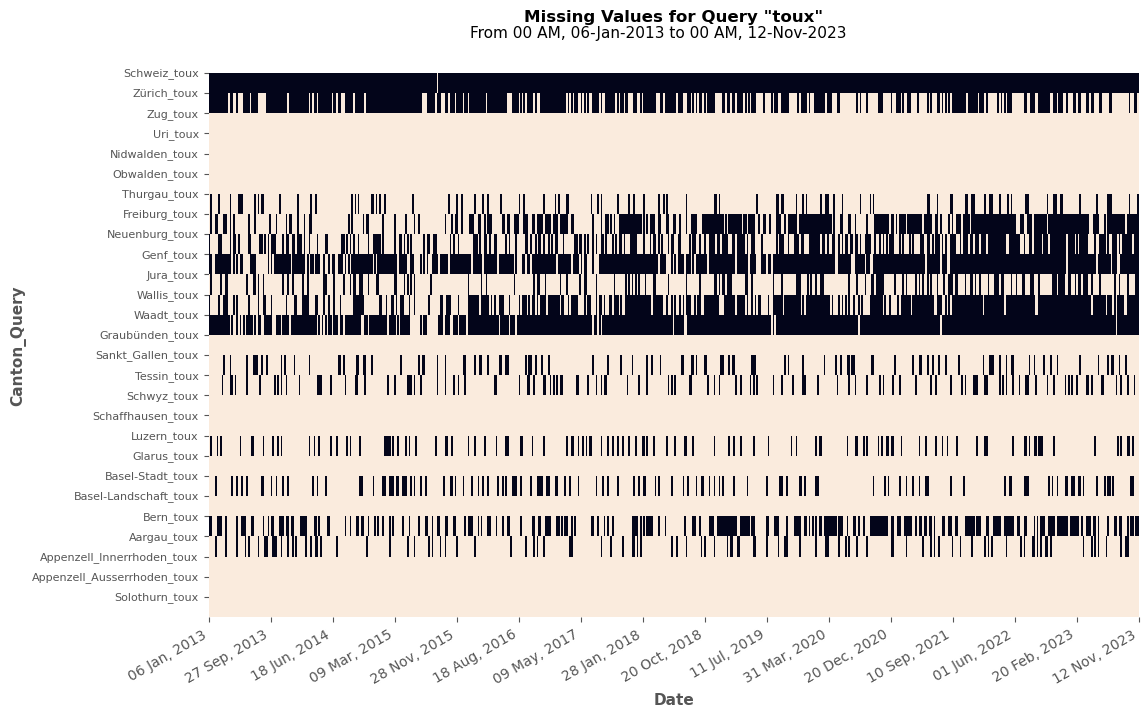

In [13]:
# Visualization of missing values through heatmaps
plot_nan.index = pd.to_datetime(plot_nan.index) # Convert index to datetime for plotting
for query in google_trends_ch.columns.levels[1]: 
    selected_columns = plot_nan.filter(like=query, axis=1)
    plot_missing(selected_columns, plot_title=f'Missing Values for Query "{query}"', figsize=(12, 8))

<h3>Aggregating Cantonal to regional level</h3>

In [25]:
pop_ct = pd.read_csv("../data/INFLUENZA_oblig/data.csv")
pop_ct.head()
# Only keep aggregate observations at cantonal level 
pop_ct = pop_ct.query("sex == 'all' and type == 'all' and agegroup == 'all' and georegion_type == 'canton'")[['temporal', 'georegion', 'pop']]

pop_ct = pop_ct.pivot(index='temporal', columns='georegion', values='pop')
pop_ct.drop(columns='unknown', inplace=True)

In [26]:
# Calendar week inspection of pop_ct data
count_weeks = pop_ct.copy()
count_weeks = count_weeks.reset_index()
# Create new columns for year and calendar week
count_weeks['year'] = count_weeks['temporal'].apply(lambda x: x.split("-")[0])
count_weeks['week'] = count_weeks['temporal'].apply(lambda x: x.split("-")[1])
# Count of weeks per year shows 53 weeks in 2015 and 2020
count_weeks.groupby('year').count()['week']

year
2012     1
2013    52
2014    52
2015    53
2016    52
2017    52
2018    52
2019    52
2020    53
2021    52
2022    52
2023    46
Name: week, dtype: int64

In [27]:
# Calendar week inspection of google_trends data
yearly_counts = google_trends_ch.copy()
yearly_counts.index = pd.to_datetime(yearly_counts.index)
# Count number of index entries per year
yearly_counts = yearly_counts.resample('Y').count()
# 2017 shows 53 entries
yearly_counts['Schweiz', 'husten']

Woche
2013-12-31    52
2014-12-31    52
2015-12-31    52
2016-12-31    52
2017-12-31    53
2018-12-31    52
2019-12-31    52
2020-12-31    52
2021-12-31    52
2022-12-31    52
2023-12-31    46
Freq: A-DEC, Name: (Schweiz, husten), dtype: int64

In [28]:
# Drop mismatching rows
pop_ct = pop_ct.T.reset_index().drop(columns=['2012-W52', '2015-W53', '2020-W53'])
# Add row for 2017 to match google-trends data
pop_ct['2017-W53'] = pop_ct['2017-W52']

pop_ct.rename(columns={'georegion': 'canton'}, inplace=True)
pop_ct['canton'] = list(map(lambda x: cantons_rev[x], pop_ct['canton']))
pop_ct = pop_ct.set_index('canton')


# Create dict for mapping of dates to index of calendar week for population mapping
week_dict = {}
for year in range(2013, 2024):
    weeks = list(filter(lambda x: x.startswith(f'{year}'), google_trends_ch.T.columns))

    week_dict.update({f'{week[:4]}-W{nr+1:02d}': week for nr, week in enumerate(weeks)})

pop_ct.rename(columns=week_dict, inplace=True)
pop_ct = pop_ct.T

In [29]:
# Dictionary mapping regions to Cantons for aggregation of population
region_to_ct = {'Region_1': ['Genf', 'Neuenburg', 'Waadt', 'Wallis'], 
           'Region_2': ['Bern', 'Freiburg', 'Jura'], 
           'Region_3': ['Aargau', 'Basel-Landschaft', 'Basel-Stadt', 'Solothurn'], 
           'Region_4': ['Luzern', 'Nidwalden', 'Obwalden', 'Schwyz', 'Uri', 'Zug'], 
           'Region_5': ['Appenzell_Innerrhoden', 'Appenzell_Ausserrhoden', 'Glarus', 'Sankt_Gallen', 'Schaffhausen', 'Thurgau', 'Zürich'], 
           'Region_6': ['Graubünden', 'Tessin']}

# Insert columns for regional population numbers
for region in region_to_ct.keys():
    pop_ct[region] = pop_ct[[*region_to_ct[region]]].sum(axis=1)

# Dictionary mapping Cantons to regions for 
ct_to_reg = dict()
for key, value in region_to_ct.items():
    for ct in value:
        ct_to_reg[ct] = key

# Create new dataframe for weights as shares of regional population
ct_weights = pop_ct.copy()
for canton in cantons.keys():
    ct_weights[canton] = ct_weights[canton] / ct_weights[ct_to_reg[canton]]

In [30]:
# Add columns for weighted search activity by region
for level in google_trends_ch.columns.levels[1]:
    for region in region_to_ct.keys():
        # Initialize an empty DataFrame to store the weighted sums for each canton
        weighted_sums = pd.DataFrame()

        # Multiply the search activity for each canton by its weight and add to the DataFrame
        for canton in region_to_ct[region]:
            weighted_sums[canton] = google_trends_ch[canton, level] * ct_weights[canton]
        
        # Sum the weighted data for each canton to get the total for the region
        google_trends_ch[region, level] = weighted_sums.sum(axis=1)

Region_1: ['Genf', 'Neuenburg', 'Waadt', 'Wallis'], 
Region_2: ['Bern', 'Freiburg', 'Jura'], 
Region_3: ['Aargau', 'Basel-Landschaft', 'Basel-Stadt', 'Solothurn'], 
Region_4: ['Luzern', 'Nidwalden', 'Obwalden', 'Schwyz', 'Uri', 'Zug'], 
Region_5: ['Appenzell_Innerrhoden', 'Appenzell_Ausserrhoden', 'Glarus', 'Sankt_Gallen', 'Schaffhausen', 'Thurgau', 'Zürich'], 
Region_6: ['Graubünden', 'Tessin']


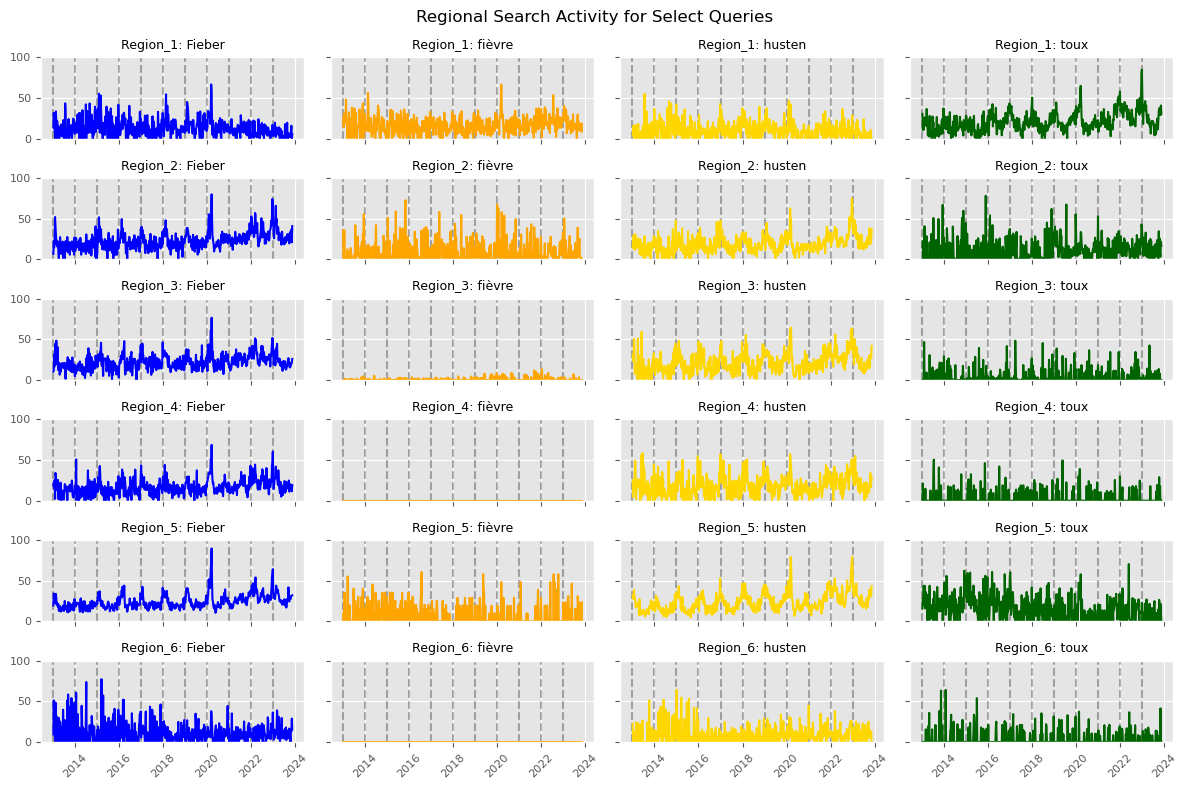

In [32]:
google_plot = google_trends_ch.copy()
google_plot.index = pd.to_datetime(google_plot.index)

# Plot regional
fig, ax = plt.subplots(6, 4, figsize=(12, 8), sharex=True, sharey=True)

# Set a common y-axis limit
y_limit = 100

# Initialize a dictionary to map queries to colors
color_dict = {'Fieber':'blue', 'fièvre':'orange', 'husten':'gold', 'toux':'darkgreen'}

i, j = 0, 0
for region in region_to_ct.keys():
    for query in google_plot.columns.levels[1]:
        for year in range(2013, 2024):
            ax[i][j].axvline(datetime(year, 1, 1), color='k', linestyle='--', alpha=0.3)
        ax[i][j].plot(google_plot[region, query], color=color_dict[query])
        ax[i][j].set_title(f'{region}: {query}', fontsize=9)
        ax[i][j].tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels
        ax[i][j].tick_params(axis='both', labelsize=8)  # Set tick label size
        ax[i][j].set_ylim([0, y_limit])  # Set y-axis limit for each subplot

        j += 1
    j = 0
    i += 1

title_parts = [f'{region}: {region_to_ct[region]}' for region in region_to_ct.keys()]

# Joining the title parts with a comma and a space
title_string = ', \n'.join(title_parts)

print(title_string)

plt.suptitle('Regional Search Activity for Select Queries')

# Adjust overall layout
plt.tight_layout()


plt.show()

/var/folders/kj/mq0jlk2574705gvzk6d37lkh0000gn/T/ipykernel_22472/3351975359.py:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (row_i, row_data) in enumerate(plot_cols.iteritems()):
/var/folders/kj/mq0jlk2574705gvzk6d37lkh0000gn/T/ipykernel_22472/3351975359.py:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for j, (col_j, col_data) in enumerate(plot_cols.iteritems()):


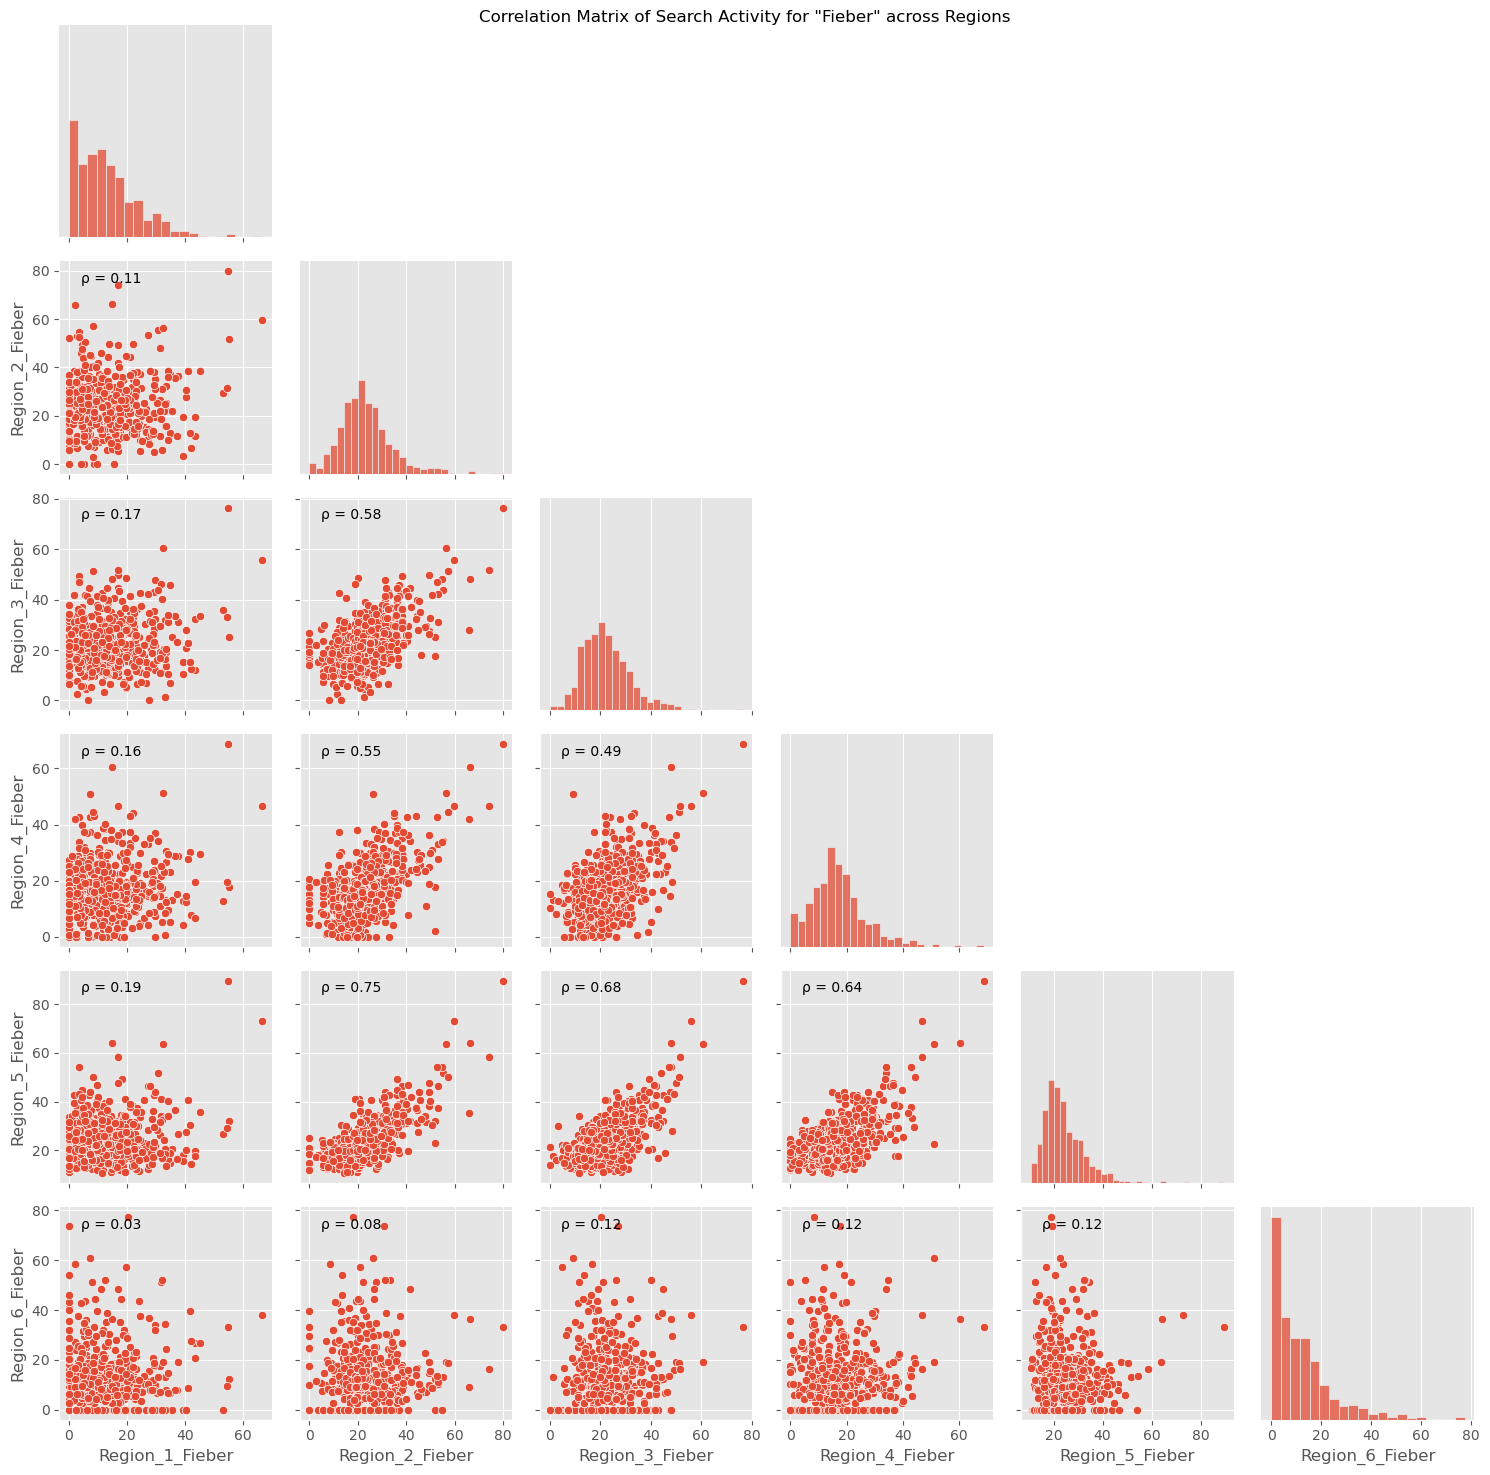

/var/folders/kj/mq0jlk2574705gvzk6d37lkh0000gn/T/ipykernel_22472/3351975359.py:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (row_i, row_data) in enumerate(plot_cols.iteritems()):
/var/folders/kj/mq0jlk2574705gvzk6d37lkh0000gn/T/ipykernel_22472/3351975359.py:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for j, (col_j, col_data) in enumerate(plot_cols.iteritems()):


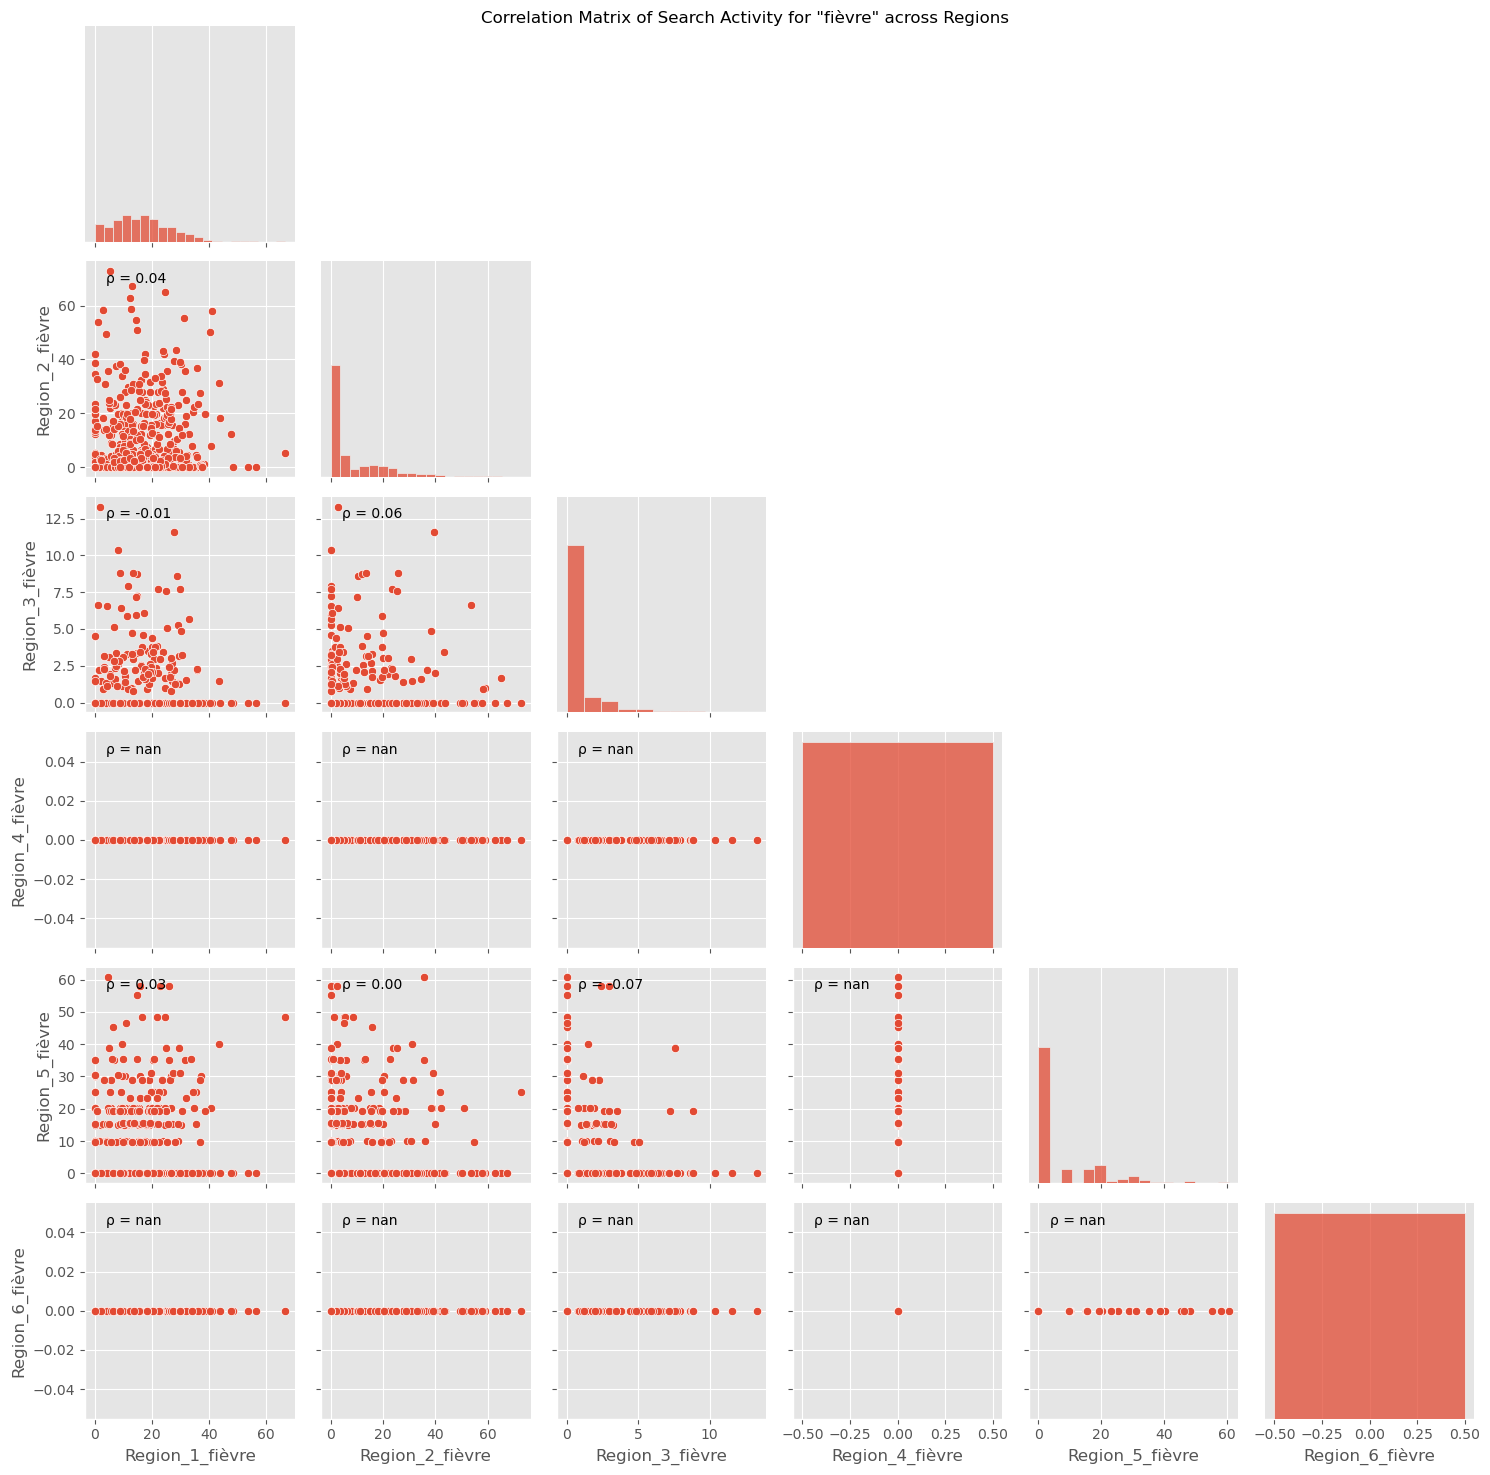

/var/folders/kj/mq0jlk2574705gvzk6d37lkh0000gn/T/ipykernel_22472/3351975359.py:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (row_i, row_data) in enumerate(plot_cols.iteritems()):
/var/folders/kj/mq0jlk2574705gvzk6d37lkh0000gn/T/ipykernel_22472/3351975359.py:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for j, (col_j, col_data) in enumerate(plot_cols.iteritems()):


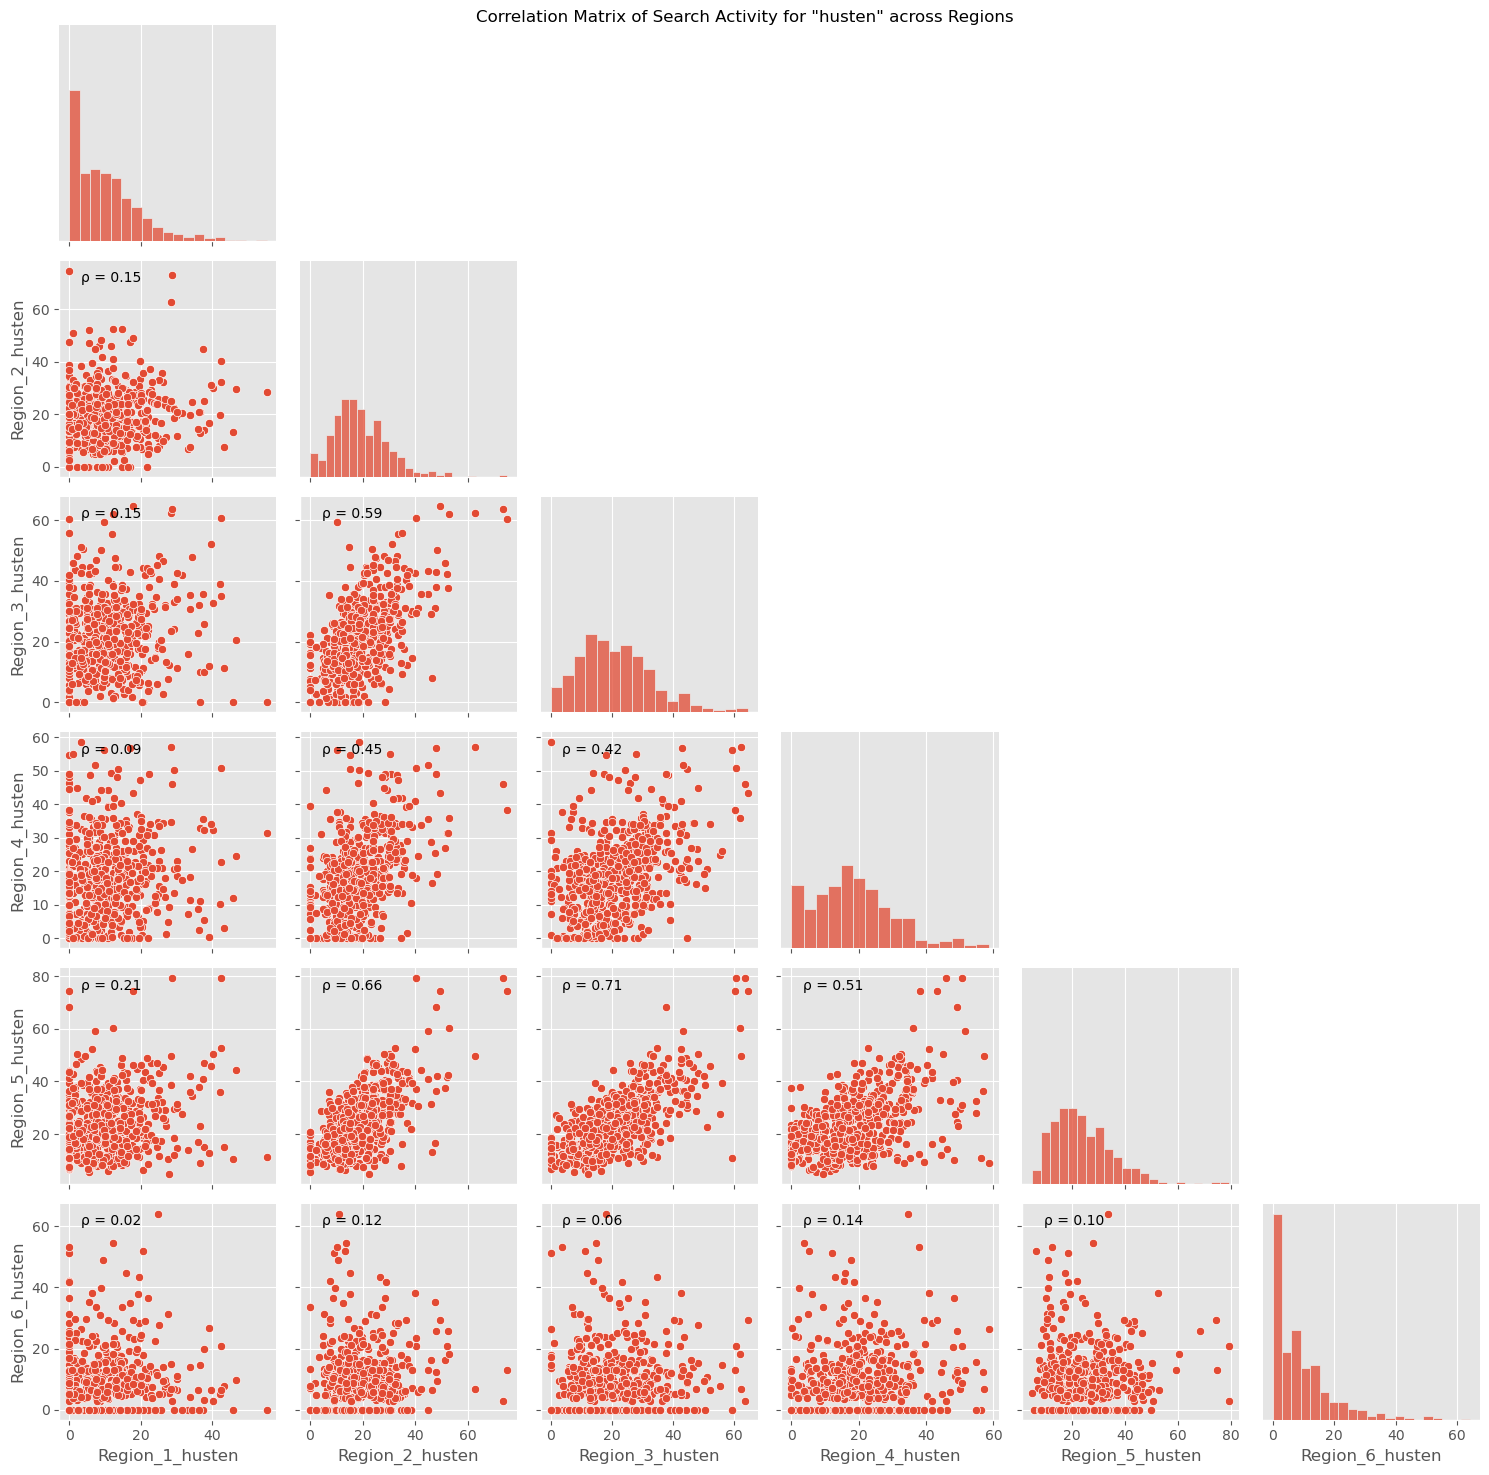

/var/folders/kj/mq0jlk2574705gvzk6d37lkh0000gn/T/ipykernel_22472/3351975359.py:8: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (row_i, row_data) in enumerate(plot_cols.iteritems()):
/var/folders/kj/mq0jlk2574705gvzk6d37lkh0000gn/T/ipykernel_22472/3351975359.py:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for j, (col_j, col_data) in enumerate(plot_cols.iteritems()):


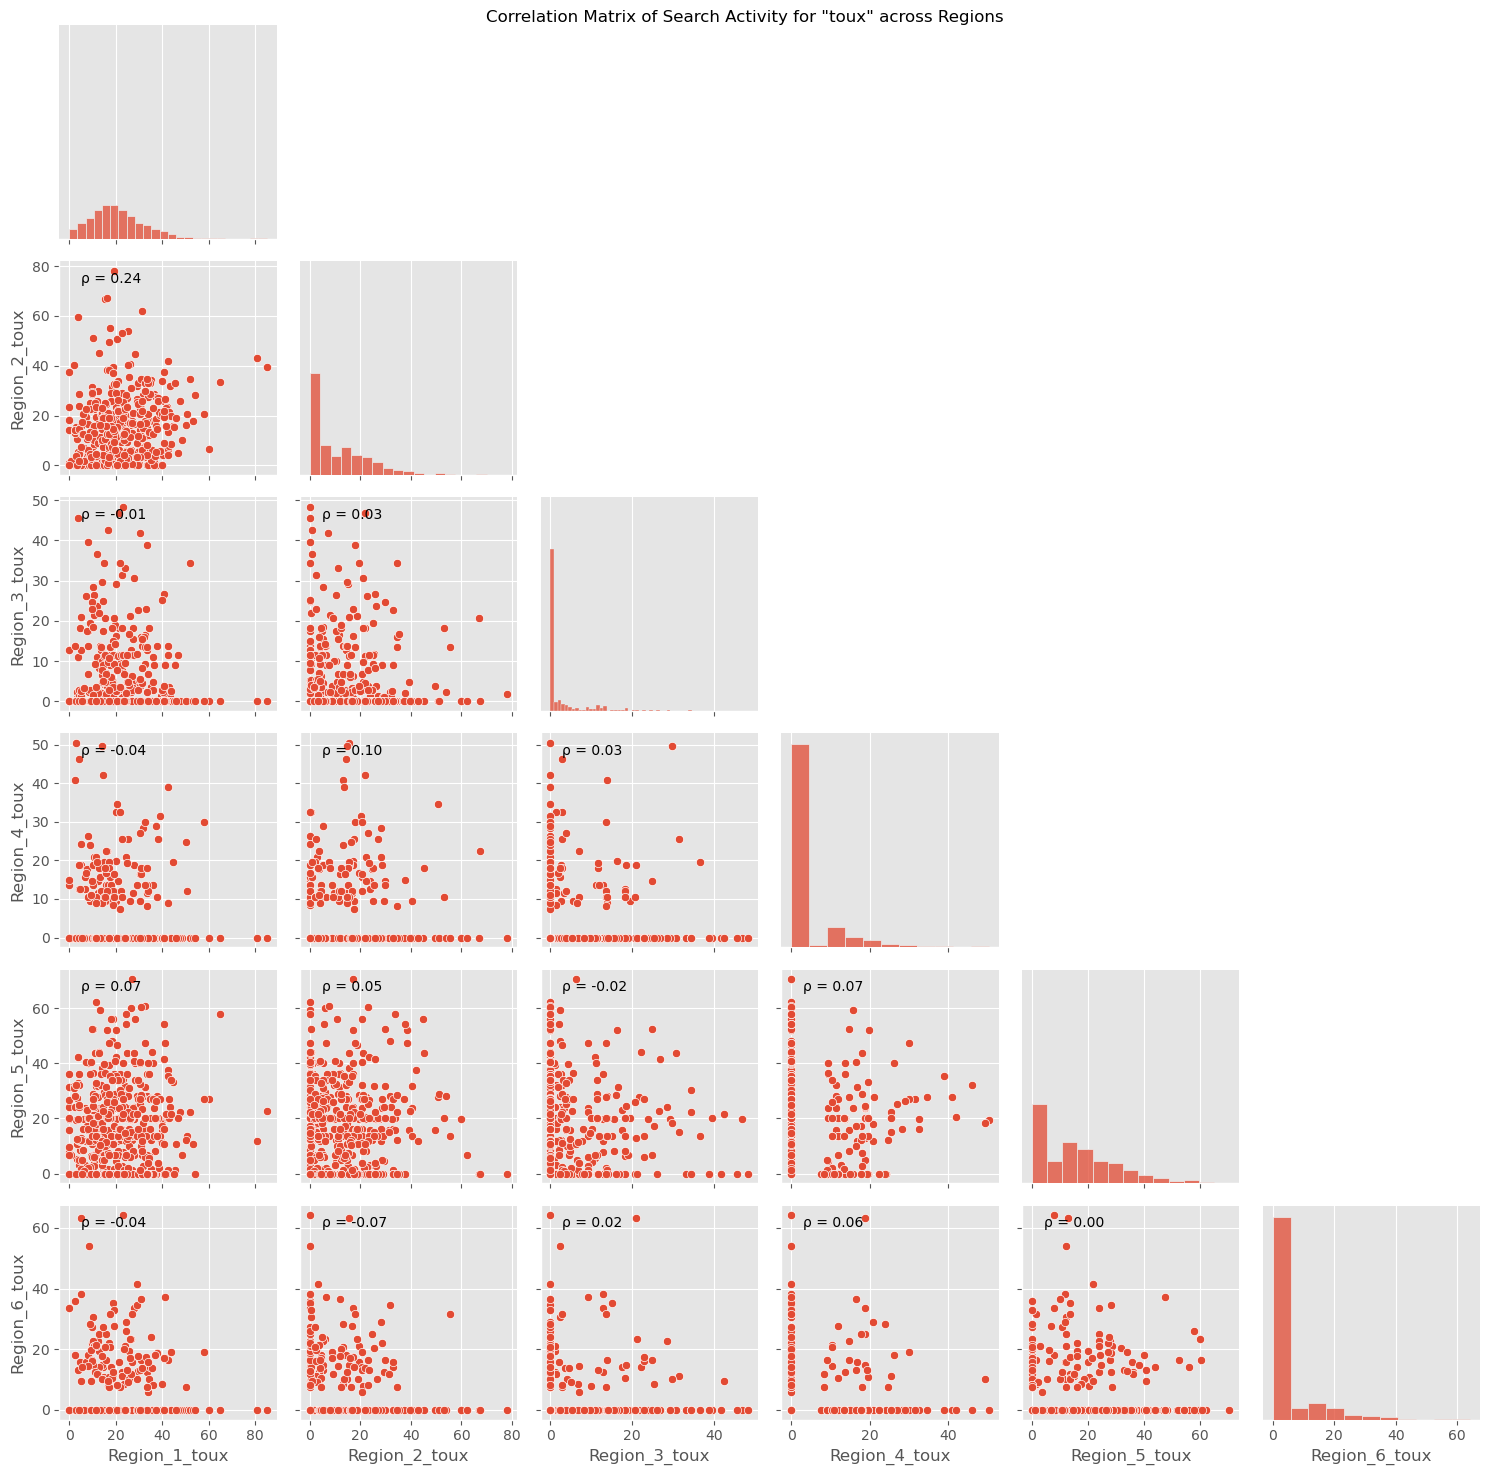

In [34]:
regional_data = google_plot.loc[:, google_plot.columns.get_level_values(0).str.startswith('Region')].copy()
regional_data.columns = list(map(lambda x: "_".join(x), regional_data.columns))
for query in google_plot.columns.levels[1]:
    plot_cols = regional_data.loc[:, regional_data.columns.str.contains(query)]
    g = sns.pairplot(plot_cols, kind='scatter', corner=True)

    # Calculate and annotate correlation coefficients
    for i, (row_i, row_data) in enumerate(plot_cols.iteritems()):
        for j, (col_j, col_data) in enumerate(plot_cols.iteritems()):
            if i > j:
                ax = g.axes[i, j]
                corr = col_data.corr(row_data)
                ax.text(0.1, 0.9, f"ρ = {corr:.2f}", transform=ax.transAxes)

    plt.suptitle(f'Correlation Matrix of Search Activity for "{query}" across Regions')

    # Show the plot
    plt.tight_layout()
    plt.show()

<h3>Decomposition of Regional Data</h3>

In [35]:
# Import statsmodels library
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from helpers import stl_decomposition, plot_anomalies, plot_estimated
from datetime import datetime

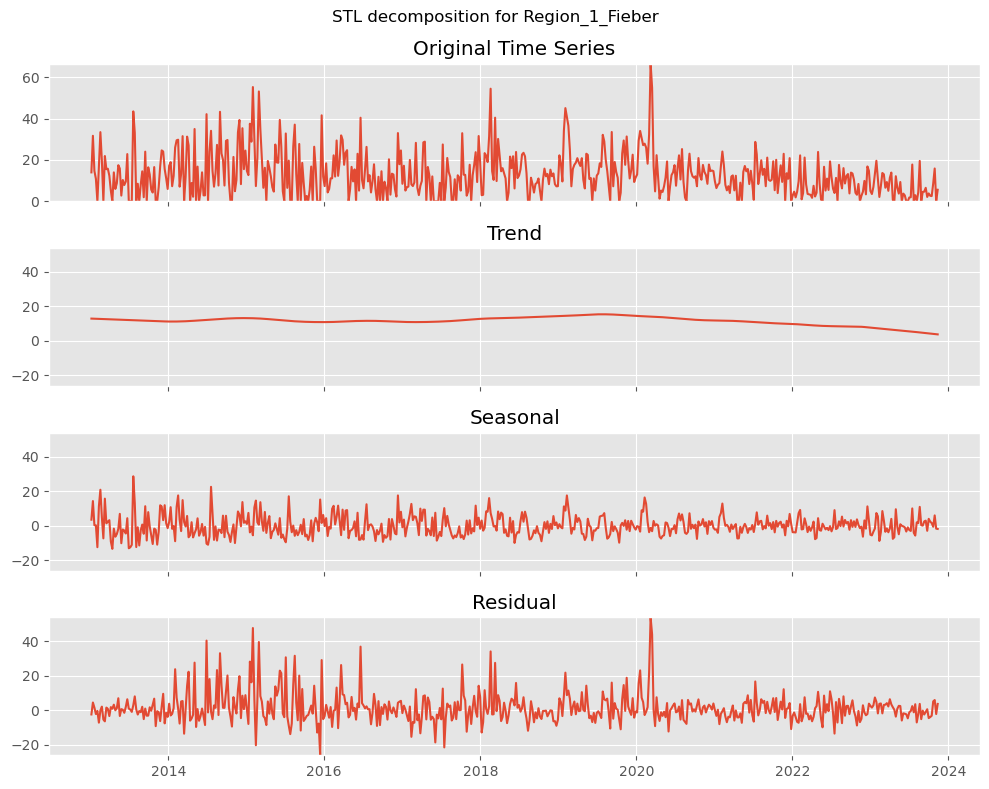

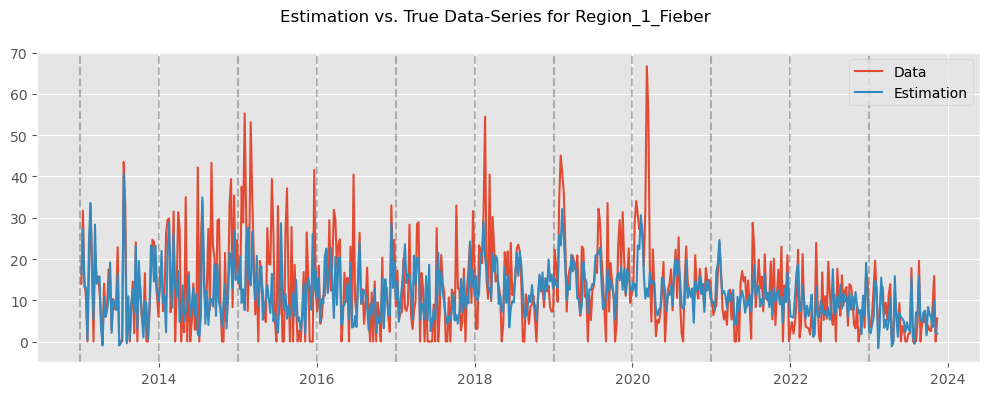

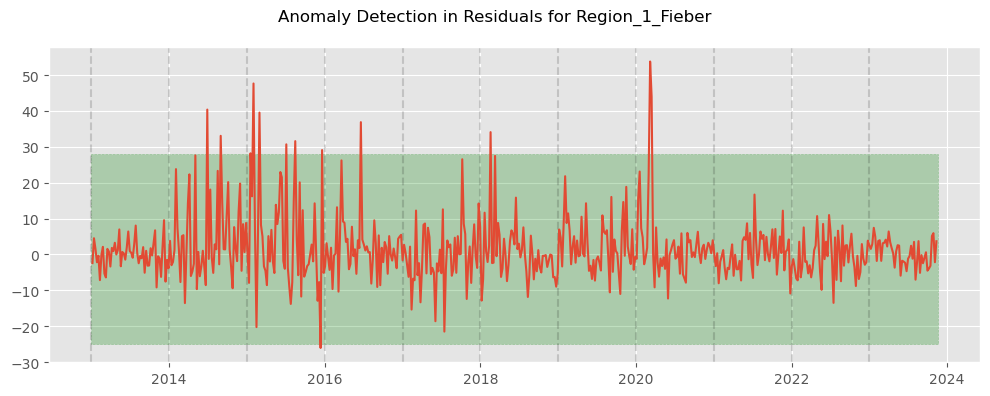

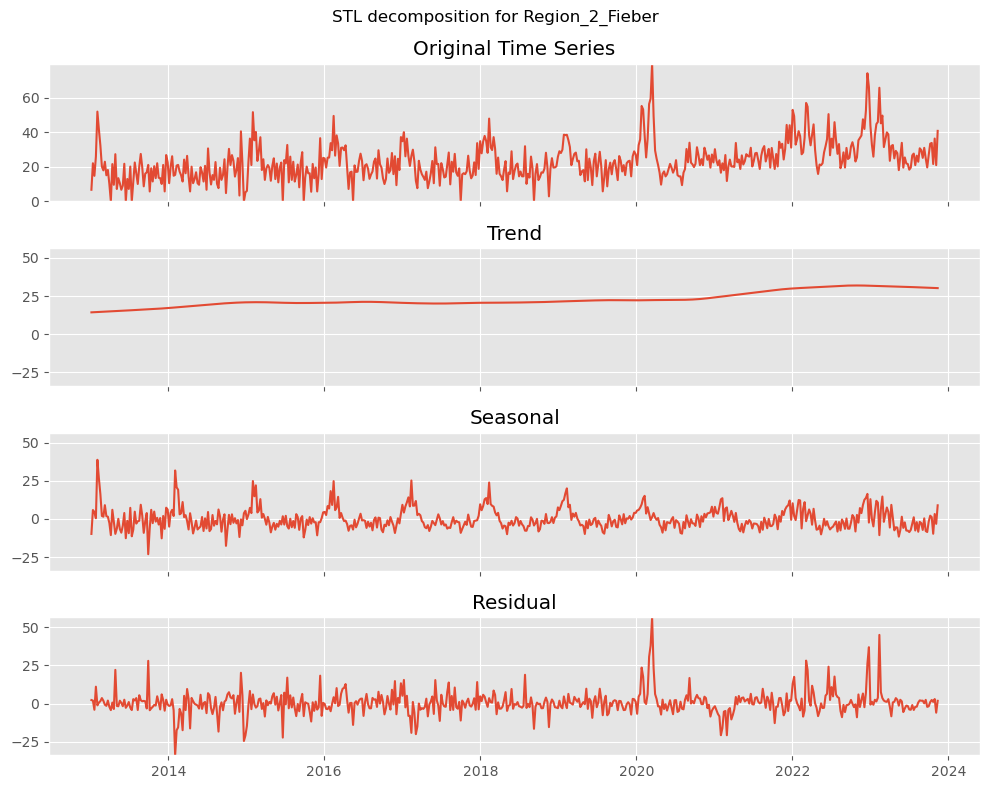

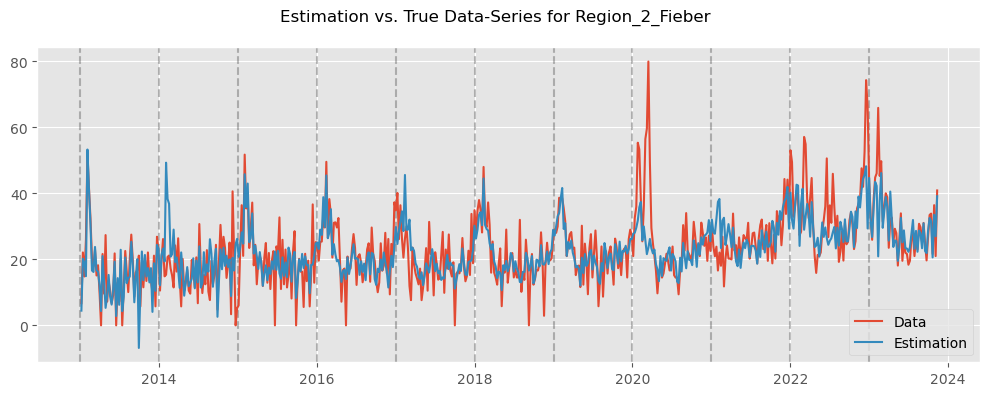

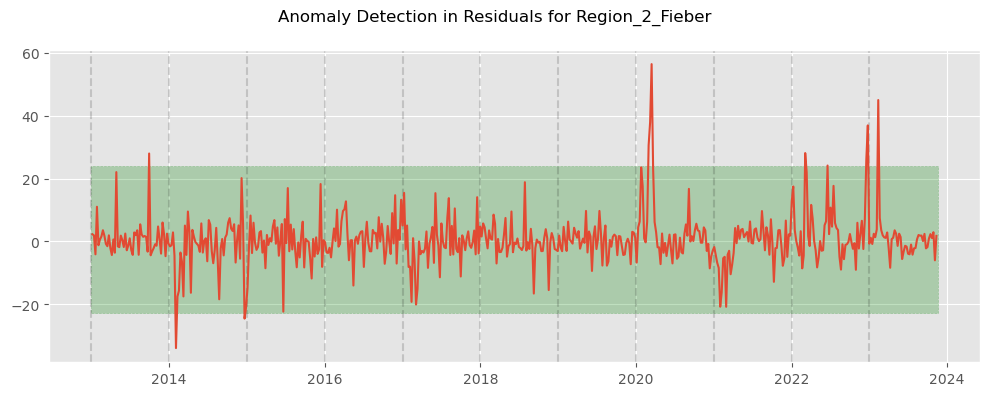

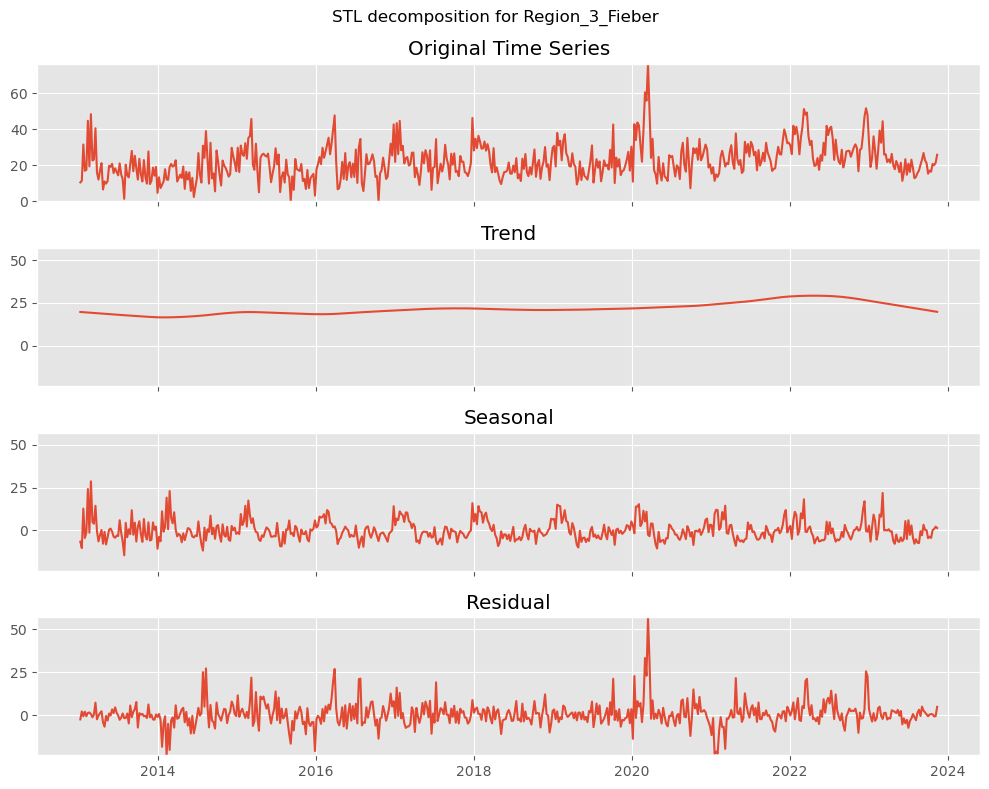

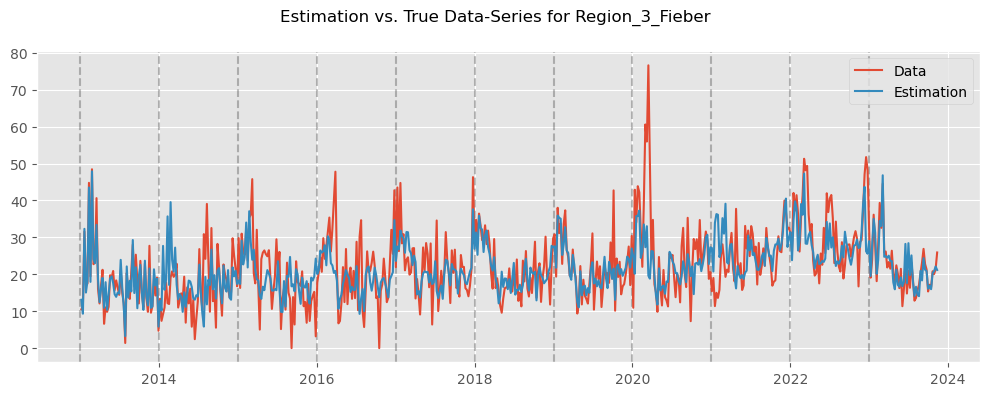

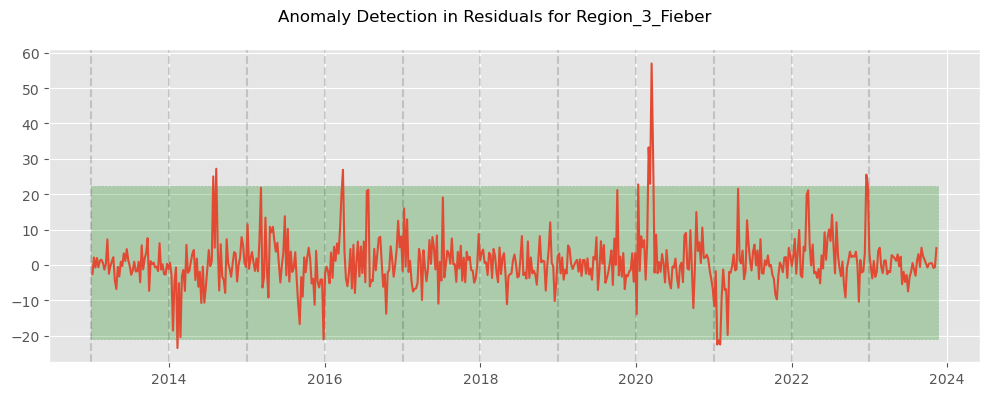

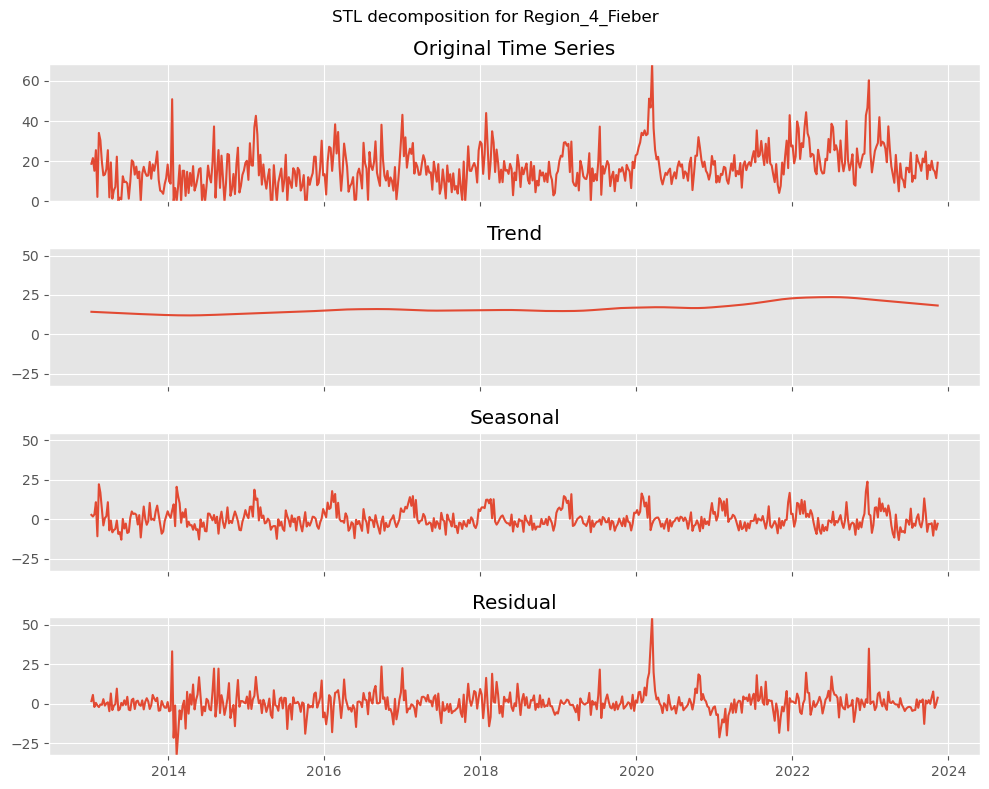

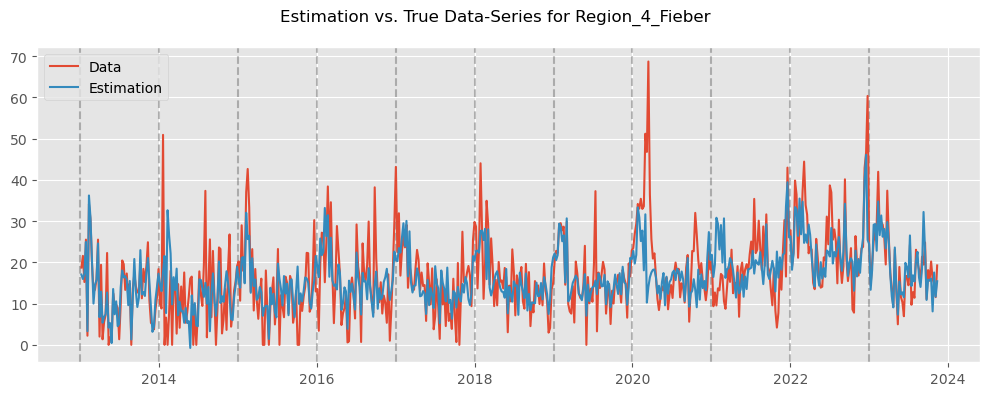

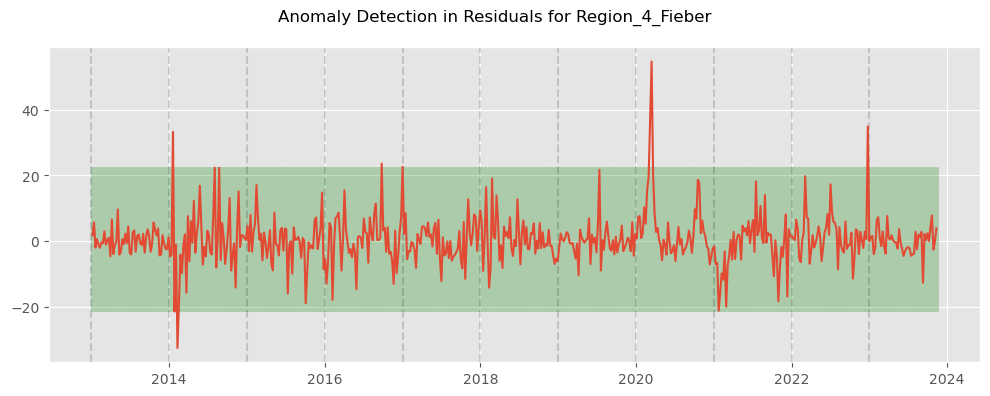

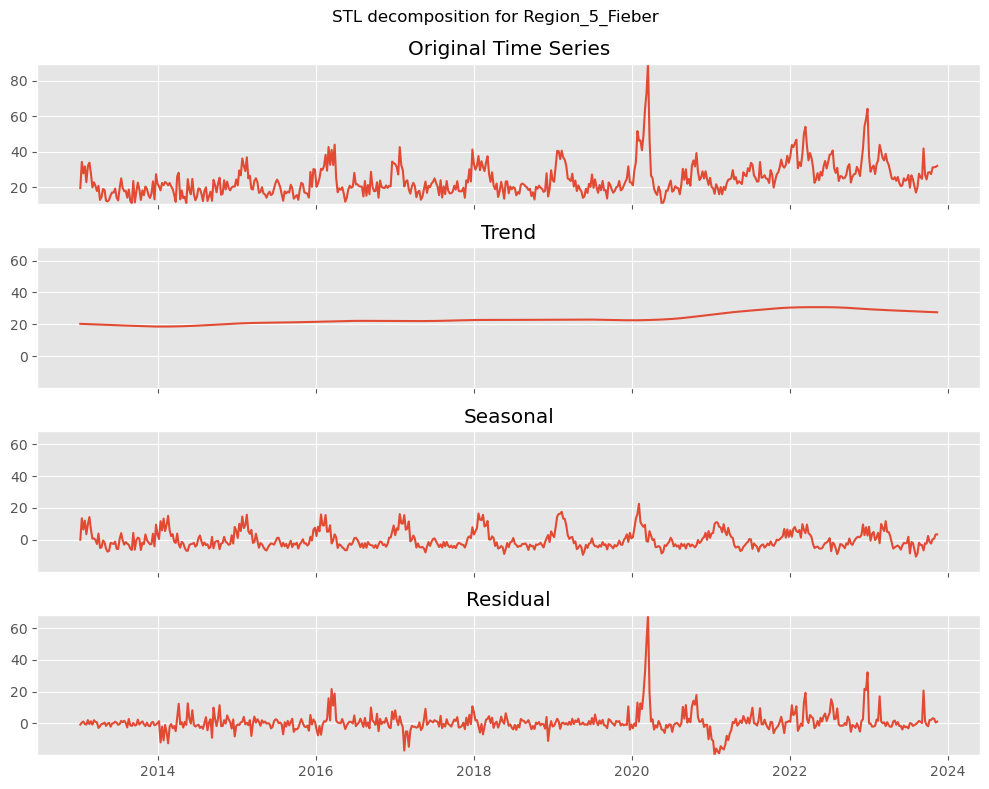

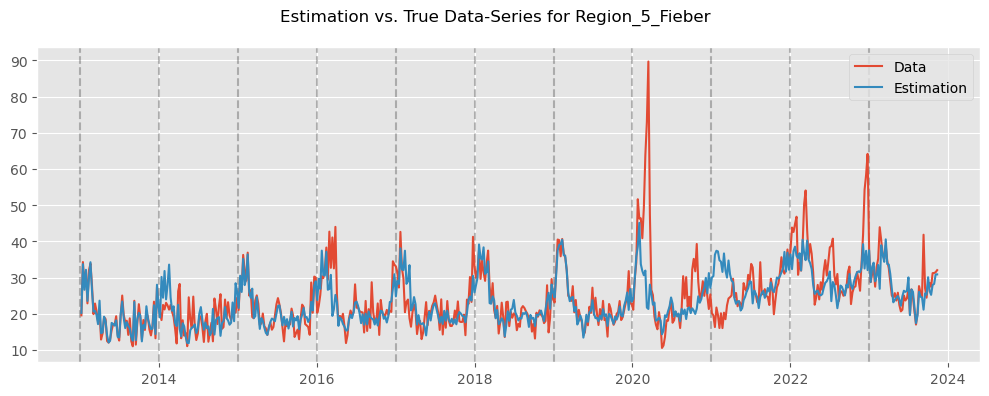

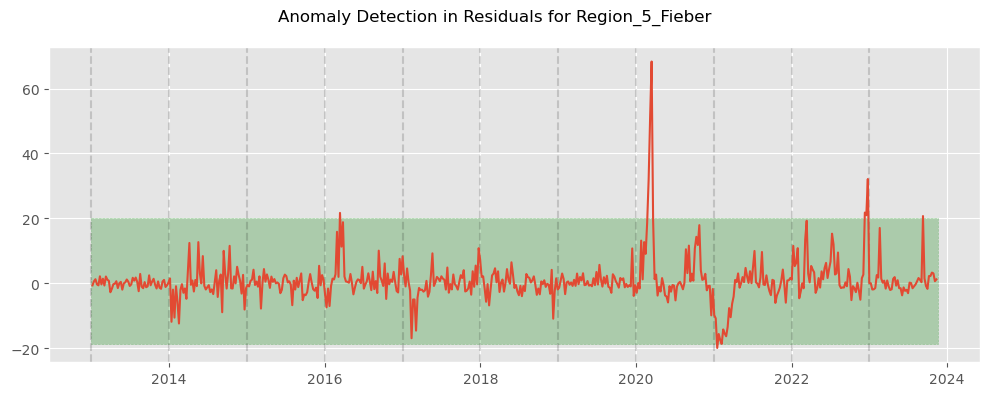

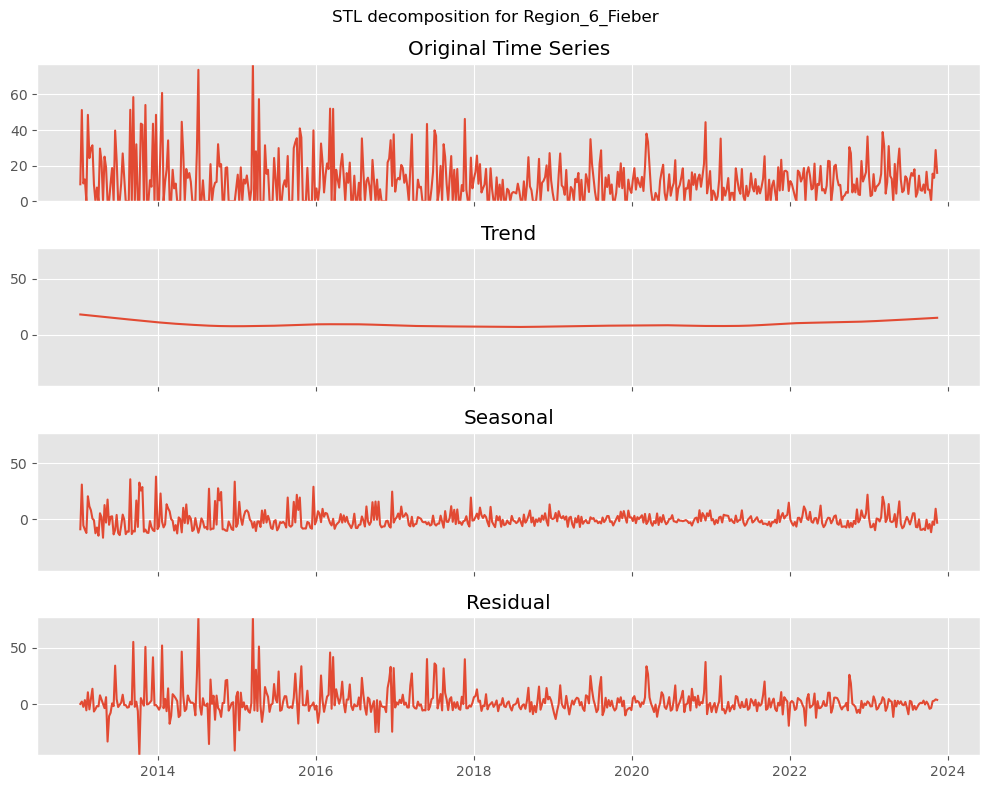

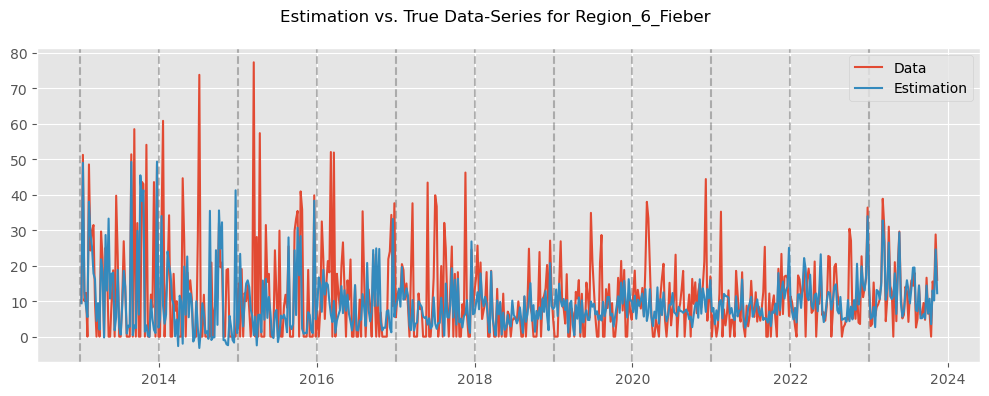

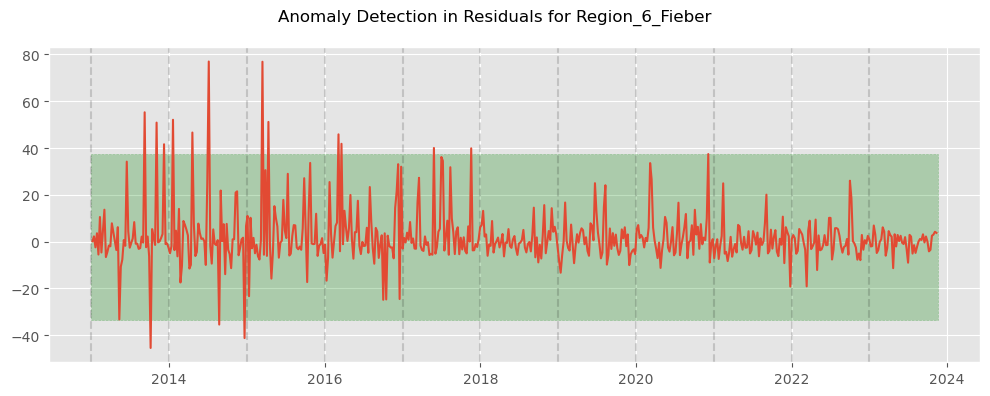

In [41]:
selected_columns = [col for col in regional_data.columns if 'Fieber' in col]
for col in selected_columns:
    decomposition = stl_decomposition(regional_data[col], period=52)
    plot_estimated(regional_data[col], decomposition)
    plot_anomalies(regional_data[col], decomposition)